In [10]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import torch.fft
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Initialize seed
seed = 42  # You can choose any integer value for the seed
set_seed(seed)
base_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
device="cuda"

# Custom Dataset Class
class FFTShiftedMNIST(Dataset):
    def __init__(self, train=True):
        self.dataset = datasets.MNIST(root='./data', train=train, download=True, transform=base_transform)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = image.to("cuda")
        
        # Apply FFT, shift, and get magnitude and phase
        fft = torch.fft.fft2(image.squeeze(0))  # Remove single channel dimension
        fft_shifted = torch.fft.fftshift(fft)
        magnitude = torch.abs(fft_shifted)
        phase = torch.angle(fft_shifted)
        
        # Stack magnitude and phase along the channel dimension
        transformed_image = torch.stack((magnitude, phase), dim=0)  # Shape: (2, height, width)
        
        return transformed_image, label

# Create dataset instances for train, validation, and test sets
train_dataset = FFTShiftedMNIST(train=True)
test_dataset = FFTShiftedMNIST(train=False)

# Split the training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2554859.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 210062.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1468160.08it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4444827.06it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the basic building block of ResNet (a residual block)
class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        #If the input and output dimensions do not match (either due to stride or channel number),
        #a 1x1 convolution and batch normalization are applied to the input to match the dimensions.
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the ResNet class using the basic blocks
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        """
        Initializes the ResNet model with the specified block type, number of blocks, and number of classes.

        Parameters:
            block (torch.nn.Module): The basic block type for the ResNet.
            num_blocks (list): A list of integers specifying the number of blocks in each layer.
            num_classes (int, optional): The number of output classes. Default is 1000.

        Initializes the convolutional layers, batch normalization layers, max pooling layer, residual layers, adaptive average pooling layer, and fully connected layer.
        """
        super(ResNet, self).__init__()
        self.in_channels = 64
        # define the stem blocks of the network
        self.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # define the residual layers of the network
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # define the average pooling layer and the fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Create a sequential layer by repeating a given block multiple times based on the number of blocks.
        
        Parameters:
            block: The block to be repeated.
            out_channels: The number of output channels in the block.
            num_blocks: The total number of blocks to create.
            stride: The stride value for each block.
        
        Returns:
            A sequential layer containing the repeated blocks.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the ResNet model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).

        This method performs the forward pass of the ResNet model. It takes an input tensor `x` and applies a series of convolutional layers, batch normalization layers, and activation functions. The input is first passed through a convolutional layer, batch normalization layer, and ReLU activation function. Then, it is passed through a max pooling layer. 

        The model then applies a series of residual blocks (`layer1`, `layer2`, `layer3`, `layer4`) which each consist of two convolutional layers, batch normalization layers, and activation functions. The residual connections allow the model to learn more complex and deeper representations of the input data.

        After the residual blocks, the input is passed through an average pooling layer and then flattened to a 1D tensor. Finally, the flattened tensor is passed through a fully connected layer (`fc`) to produce the output tensor.

        Note: The number of channels in the input tensor (`channels`) must match the number of channels in the first convolutional layer of the model.
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout for regularization
        x = self.fc(x)
        return x

def ResNet34(num_classes=1000):
    return ResNet(ResBlock, [3, 4, 6, 3], num_classes)

model = ResNet34(10)
model.to("cuda")

ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [15]:
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
num_epochs = 500
patience = 10  
best_val_loss = float('inf')
epochs_since_improvement = 0
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [5]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [6]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader:
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

            pbar.set_postfix(loss=running_loss / (pbar.n + 1))
            pbar.update()

    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
            for inputs, targets in val_loader:
                targets = targets.to("cuda")
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                scheduler.step(val_loss)
                pbar.update()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.2f}%')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
        if epochs_since_improvement >= patience:
            print("Early stopping triggered")
            break



Epoch 1/500: 100%|██████████| 750/750 [02:47<00:00,  4.48batch/s, loss=1.48]


Epoch [1/500], Training Loss: 1.4774, Accuracy: 65.67%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.21batch/s]


Validation Loss: 1.6824, Accuracy: 54.22%


Epoch 2/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.13]


Epoch [2/500], Training Loss: 1.1346, Accuracy: 87.71%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.14batch/s]


Validation Loss: 1.0932, Accuracy: 88.80%


Epoch 3/500: 100%|██████████| 750/750 [02:45<00:00,  4.54batch/s, loss=1.13]


Epoch [3/500], Training Loss: 1.1344, Accuracy: 87.86%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.12batch/s]


Validation Loss: 1.0986, Accuracy: 88.80%


Epoch 4/500: 100%|██████████| 750/750 [02:45<00:00,  4.54batch/s, loss=1.13]


Epoch [4/500], Training Loss: 1.1342, Accuracy: 87.78%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.14batch/s]


Validation Loss: 1.0943, Accuracy: 88.79%


Epoch 5/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.13]


Epoch [5/500], Training Loss: 1.1324, Accuracy: 87.91%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.14batch/s]


Validation Loss: 1.0857, Accuracy: 89.22%


Epoch 6/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.13]


Epoch [6/500], Training Loss: 1.1323, Accuracy: 87.87%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.24batch/s]


Validation Loss: 1.0893, Accuracy: 89.12%


Epoch 7/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.13]


Epoch [7/500], Training Loss: 1.1297, Accuracy: 87.96%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.07batch/s]


Validation Loss: 1.0929, Accuracy: 88.88%


Epoch 8/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.13]


Epoch [8/500], Training Loss: 1.1291, Accuracy: 88.02%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.18batch/s]


Validation Loss: 1.0844, Accuracy: 89.39%


Epoch 9/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.13]


Epoch [9/500], Training Loss: 1.1275, Accuracy: 88.13%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.21batch/s]


Validation Loss: 1.0860, Accuracy: 89.32%


Epoch 10/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.13]


Epoch [10/500], Training Loss: 1.1282, Accuracy: 88.35%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.09batch/s]


Validation Loss: 1.0829, Accuracy: 89.50%


Epoch 11/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.13]


Epoch [11/500], Training Loss: 1.1259, Accuracy: 88.17%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.24batch/s]


Validation Loss: 1.0916, Accuracy: 88.94%


Epoch 12/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.12]


Epoch [12/500], Training Loss: 1.1200, Accuracy: 88.58%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.08batch/s]


Validation Loss: 1.0883, Accuracy: 89.09%


Epoch 13/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.12]


Epoch [13/500], Training Loss: 1.1240, Accuracy: 88.37%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0863, Accuracy: 89.26%


Epoch 14/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.12]


Epoch [14/500], Training Loss: 1.1240, Accuracy: 88.30%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.14batch/s]


Validation Loss: 1.0843, Accuracy: 89.42%


Epoch 15/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.12]


Epoch [15/500], Training Loss: 1.1208, Accuracy: 88.54%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.12batch/s]


Validation Loss: 1.0766, Accuracy: 89.90%


Epoch 16/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.12]


Epoch [16/500], Training Loss: 1.1209, Accuracy: 88.54%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.18batch/s]


Validation Loss: 1.0824, Accuracy: 89.47%


Epoch 17/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.12]


Epoch [17/500], Training Loss: 1.1179, Accuracy: 88.71%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.15batch/s]


Validation Loss: 1.0821, Accuracy: 89.69%


Epoch 18/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.12]


Epoch [18/500], Training Loss: 1.1193, Accuracy: 88.57%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.22batch/s]


Validation Loss: 1.0733, Accuracy: 90.12%


Epoch 19/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.12]


Epoch [19/500], Training Loss: 1.1183, Accuracy: 88.51%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.18batch/s]


Validation Loss: 1.0755, Accuracy: 89.96%


Epoch 20/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.12]


Epoch [20/500], Training Loss: 1.1164, Accuracy: 88.71%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.23batch/s]


Validation Loss: 1.0799, Accuracy: 89.62%


Epoch 21/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.12]


Epoch [21/500], Training Loss: 1.1153, Accuracy: 88.88%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.18batch/s]


Validation Loss: 1.0751, Accuracy: 89.98%


Epoch 22/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.12]


Epoch [22/500], Training Loss: 1.1167, Accuracy: 88.71%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.20batch/s]


Validation Loss: 1.0749, Accuracy: 89.86%


Epoch 23/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.11]


Epoch [23/500], Training Loss: 1.1149, Accuracy: 88.86%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.25batch/s]


Validation Loss: 1.0826, Accuracy: 89.60%


Epoch 24/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.11]


Epoch [24/500], Training Loss: 1.1131, Accuracy: 88.95%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.25batch/s]


Validation Loss: 1.0786, Accuracy: 89.80%


Epoch 25/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.11]


Epoch [25/500], Training Loss: 1.1138, Accuracy: 88.94%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.05batch/s]


Validation Loss: 1.0800, Accuracy: 89.74%


Epoch 26/500: 100%|██████████| 750/750 [02:45<00:00,  4.54batch/s, loss=1.11]


Epoch [26/500], Training Loss: 1.1128, Accuracy: 89.02%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.22batch/s]


Validation Loss: 1.0701, Accuracy: 90.27%


Epoch 27/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.11]


Epoch [27/500], Training Loss: 1.1126, Accuracy: 88.92%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.16batch/s]


Validation Loss: 1.0733, Accuracy: 89.96%


Epoch 28/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.11]


Epoch [28/500], Training Loss: 1.1113, Accuracy: 88.94%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.18batch/s]


Validation Loss: 1.0678, Accuracy: 90.50%


Epoch 29/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.11]


Epoch [29/500], Training Loss: 1.1104, Accuracy: 89.19%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.28batch/s]


Validation Loss: 1.0729, Accuracy: 90.05%


Epoch 30/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.11]


Epoch [30/500], Training Loss: 1.1113, Accuracy: 89.12%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.86batch/s]


Validation Loss: 1.0704, Accuracy: 90.34%


Epoch 31/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.11]


Epoch [31/500], Training Loss: 1.1104, Accuracy: 89.08%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.06batch/s]


Validation Loss: 1.0721, Accuracy: 90.08%


Epoch 32/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.11]


Epoch [32/500], Training Loss: 1.1086, Accuracy: 89.18%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.23batch/s]


Validation Loss: 1.0726, Accuracy: 89.99%


Epoch 33/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.11]


Epoch [33/500], Training Loss: 1.1090, Accuracy: 89.24%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.19batch/s]


Validation Loss: 1.0701, Accuracy: 90.20%


Epoch 34/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.11]


Epoch [34/500], Training Loss: 1.1090, Accuracy: 89.10%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.27batch/s]


Validation Loss: 1.0692, Accuracy: 90.29%


Epoch 35/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.11]


Epoch [35/500], Training Loss: 1.1088, Accuracy: 89.01%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.69batch/s]


Validation Loss: 1.0677, Accuracy: 90.39%


Epoch 36/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.11]


Epoch [36/500], Training Loss: 1.1072, Accuracy: 89.34%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.85batch/s]


Validation Loss: 1.0683, Accuracy: 90.38%


Epoch 37/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.11]


Epoch [37/500], Training Loss: 1.1055, Accuracy: 89.36%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.20batch/s]


Validation Loss: 1.0682, Accuracy: 90.22%


Epoch 38/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.1]


Epoch [38/500], Training Loss: 1.1046, Accuracy: 89.56%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.20batch/s]


Validation Loss: 1.0699, Accuracy: 90.24%


Epoch 39/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [39/500], Training Loss: 1.1050, Accuracy: 89.34%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.22batch/s]


Validation Loss: 1.0657, Accuracy: 90.44%


Epoch 40/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.1]


Epoch [40/500], Training Loss: 1.1044, Accuracy: 89.36%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.24batch/s]


Validation Loss: 1.0670, Accuracy: 90.29%


Epoch 41/500: 100%|██████████| 750/750 [02:46<00:00,  4.49batch/s, loss=1.1]


Epoch [41/500], Training Loss: 1.1022, Accuracy: 89.54%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.25batch/s]


Validation Loss: 1.0652, Accuracy: 90.56%


Epoch 42/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.1]


Epoch [42/500], Training Loss: 1.1038, Accuracy: 89.40%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.23batch/s]


Validation Loss: 1.0662, Accuracy: 90.49%


Epoch 43/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.1]


Epoch [43/500], Training Loss: 1.1044, Accuracy: 89.55%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.84batch/s]


Validation Loss: 1.0647, Accuracy: 90.58%


Epoch 44/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.1]


Epoch [44/500], Training Loss: 1.1043, Accuracy: 89.47%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.27batch/s]


Validation Loss: 1.0662, Accuracy: 90.42%


Epoch 45/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [45/500], Training Loss: 1.1026, Accuracy: 89.59%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.21batch/s]


Validation Loss: 1.0631, Accuracy: 90.54%


Epoch 46/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.1]


Epoch [46/500], Training Loss: 1.1001, Accuracy: 89.70%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.25batch/s]


Validation Loss: 1.0694, Accuracy: 90.19%


Epoch 47/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [47/500], Training Loss: 1.1034, Accuracy: 89.49%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.26batch/s]


Validation Loss: 1.0628, Accuracy: 90.63%


Epoch 48/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.1]


Epoch [48/500], Training Loss: 1.0996, Accuracy: 89.61%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.29batch/s]


Validation Loss: 1.0642, Accuracy: 90.66%


Epoch 49/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.1]


Epoch [49/500], Training Loss: 1.1021, Accuracy: 89.62%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.26batch/s]


Validation Loss: 1.0622, Accuracy: 90.68%


Epoch 50/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.1]


Epoch [50/500], Training Loss: 1.1012, Accuracy: 89.74%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.10batch/s]


Validation Loss: 1.0619, Accuracy: 90.65%


Epoch 51/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [51/500], Training Loss: 1.1008, Accuracy: 89.62%


Validation: 100%|██████████| 188/188 [00:18<00:00,  9.95batch/s]


Validation Loss: 1.0627, Accuracy: 90.66%


Epoch 52/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [52/500], Training Loss: 1.1015, Accuracy: 89.56%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.19batch/s]


Validation Loss: 1.0649, Accuracy: 90.53%


Epoch 53/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.1]


Epoch [53/500], Training Loss: 1.0981, Accuracy: 89.85%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0663, Accuracy: 90.42%


Epoch 54/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.1]


Epoch [54/500], Training Loss: 1.0999, Accuracy: 89.64%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.26batch/s]


Validation Loss: 1.0607, Accuracy: 90.69%


Epoch 55/500: 100%|██████████| 750/750 [02:45<00:00,  4.54batch/s, loss=1.1]


Epoch [55/500], Training Loss: 1.0995, Accuracy: 89.72%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.29batch/s]


Validation Loss: 1.0612, Accuracy: 90.67%


Epoch 56/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.1]


Epoch [56/500], Training Loss: 1.0981, Accuracy: 89.88%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0635, Accuracy: 90.51%


Epoch 57/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [57/500], Training Loss: 1.0984, Accuracy: 89.71%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.02batch/s]


Validation Loss: 1.0609, Accuracy: 90.66%


Epoch 58/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.1]


Epoch [58/500], Training Loss: 1.0982, Accuracy: 89.78%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.23batch/s]


Validation Loss: 1.0638, Accuracy: 90.44%


Epoch 59/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.1]


Epoch [59/500], Training Loss: 1.1004, Accuracy: 89.56%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.22batch/s]


Validation Loss: 1.0625, Accuracy: 90.58%


Epoch 60/500: 100%|██████████| 750/750 [02:45<00:00,  4.54batch/s, loss=1.1]


Epoch [60/500], Training Loss: 1.0977, Accuracy: 89.84%


Validation: 100%|██████████| 188/188 [00:18<00:00,  9.98batch/s]


Validation Loss: 1.0612, Accuracy: 90.67%


Epoch 61/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.1]


Epoch [61/500], Training Loss: 1.0967, Accuracy: 89.91%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.35batch/s]


Validation Loss: 1.0588, Accuracy: 90.83%


Epoch 62/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.1]


Epoch [62/500], Training Loss: 1.0976, Accuracy: 89.85%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.83batch/s]


Validation Loss: 1.0627, Accuracy: 90.58%


Epoch 63/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [63/500], Training Loss: 1.0958, Accuracy: 90.00%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.25batch/s]


Validation Loss: 1.0620, Accuracy: 90.62%


Epoch 64/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.1]


Epoch [64/500], Training Loss: 1.0955, Accuracy: 89.89%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.25batch/s]


Validation Loss: 1.0638, Accuracy: 90.60%


Epoch 65/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.1]


Epoch [65/500], Training Loss: 1.0970, Accuracy: 89.84%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.75batch/s]


Validation Loss: 1.0592, Accuracy: 90.77%


Epoch 66/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [66/500], Training Loss: 1.0957, Accuracy: 89.88%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.28batch/s]


Validation Loss: 1.0595, Accuracy: 90.87%


Epoch 67/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [67/500], Training Loss: 1.0948, Accuracy: 89.99%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.22batch/s]


Validation Loss: 1.0590, Accuracy: 90.88%


Epoch 68/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [68/500], Training Loss: 1.0941, Accuracy: 90.10%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.26batch/s]


Validation Loss: 1.0625, Accuracy: 90.54%


Epoch 69/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [69/500], Training Loss: 1.0952, Accuracy: 89.86%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.06batch/s]


Validation Loss: 1.0596, Accuracy: 90.71%


Epoch 70/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [70/500], Training Loss: 1.0935, Accuracy: 90.05%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.87batch/s]


Validation Loss: 1.0600, Accuracy: 90.67%


Epoch 71/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.1]


Epoch [71/500], Training Loss: 1.0967, Accuracy: 89.88%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.25batch/s]


Validation Loss: 1.0572, Accuracy: 90.97%


Epoch 72/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.1]


Epoch [72/500], Training Loss: 1.0962, Accuracy: 89.91%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.07batch/s]


Validation Loss: 1.0594, Accuracy: 90.73%


Epoch 73/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [73/500], Training Loss: 1.0945, Accuracy: 89.96%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.30batch/s]


Validation Loss: 1.0585, Accuracy: 90.82%


Epoch 74/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.1]


Epoch [74/500], Training Loss: 1.0955, Accuracy: 89.88%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.23batch/s]


Validation Loss: 1.0567, Accuracy: 90.98%


Epoch 75/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [75/500], Training Loss: 1.0943, Accuracy: 89.89%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.23batch/s]


Validation Loss: 1.0585, Accuracy: 90.74%


Epoch 76/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [76/500], Training Loss: 1.0930, Accuracy: 90.10%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.26batch/s]


Validation Loss: 1.0574, Accuracy: 90.76%


Epoch 77/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [77/500], Training Loss: 1.0935, Accuracy: 90.14%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.84batch/s]


Validation Loss: 1.0573, Accuracy: 90.92%


Epoch 78/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.1]


Epoch [78/500], Training Loss: 1.0950, Accuracy: 90.09%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.19batch/s]


Validation Loss: 1.0562, Accuracy: 91.03%


Epoch 79/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [79/500], Training Loss: 1.0927, Accuracy: 90.12%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.76batch/s]


Validation Loss: 1.0557, Accuracy: 91.02%


Epoch 80/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [80/500], Training Loss: 1.0932, Accuracy: 90.00%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.26batch/s]


Validation Loss: 1.0574, Accuracy: 90.95%


Epoch 81/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [81/500], Training Loss: 1.0939, Accuracy: 90.05%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.26batch/s]


Validation Loss: 1.0568, Accuracy: 90.97%


Epoch 82/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [82/500], Training Loss: 1.0929, Accuracy: 90.03%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.19batch/s]


Validation Loss: 1.0560, Accuracy: 90.88%


Epoch 83/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.09]


Epoch [83/500], Training Loss: 1.0923, Accuracy: 90.07%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.87batch/s]


Validation Loss: 1.0556, Accuracy: 91.07%


Epoch 84/500: 100%|██████████| 750/750 [02:45<00:00,  4.54batch/s, loss=1.09]


Epoch [84/500], Training Loss: 1.0925, Accuracy: 90.13%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0552, Accuracy: 90.89%


Epoch 85/500: 100%|██████████| 750/750 [02:44<00:00,  4.55batch/s, loss=1.09]


Epoch [85/500], Training Loss: 1.0940, Accuracy: 90.12%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.31batch/s]


Validation Loss: 1.0552, Accuracy: 91.07%


Epoch 86/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [86/500], Training Loss: 1.0926, Accuracy: 90.06%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.22batch/s]


Validation Loss: 1.0587, Accuracy: 90.72%


Epoch 87/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [87/500], Training Loss: 1.0905, Accuracy: 90.20%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.23batch/s]


Validation Loss: 1.0566, Accuracy: 90.90%


Epoch 88/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [88/500], Training Loss: 1.0919, Accuracy: 90.17%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.71batch/s]


Validation Loss: 1.0604, Accuracy: 90.66%


Epoch 89/500: 100%|██████████| 750/750 [02:47<00:00,  4.49batch/s, loss=1.09]


Epoch [89/500], Training Loss: 1.0924, Accuracy: 90.12%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.14batch/s]


Validation Loss: 1.0551, Accuracy: 91.05%


Epoch 90/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [90/500], Training Loss: 1.0922, Accuracy: 90.10%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.11batch/s]


Validation Loss: 1.0549, Accuracy: 91.06%


Epoch 91/500: 100%|██████████| 750/750 [02:47<00:00,  4.49batch/s, loss=1.09]


Epoch [91/500], Training Loss: 1.0916, Accuracy: 89.98%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0560, Accuracy: 91.00%


Epoch 92/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [92/500], Training Loss: 1.0910, Accuracy: 90.17%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.20batch/s]


Validation Loss: 1.0547, Accuracy: 91.07%


Epoch 93/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [93/500], Training Loss: 1.0910, Accuracy: 90.03%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.11batch/s]


Validation Loss: 1.0580, Accuracy: 90.73%


Epoch 94/500: 100%|██████████| 750/750 [02:47<00:00,  4.48batch/s, loss=1.09]


Epoch [94/500], Training Loss: 1.0899, Accuracy: 90.26%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.21batch/s]


Validation Loss: 1.0548, Accuracy: 90.88%


Epoch 95/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [95/500], Training Loss: 1.0905, Accuracy: 90.24%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.16batch/s]


Validation Loss: 1.0563, Accuracy: 90.89%


Epoch 96/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [96/500], Training Loss: 1.0933, Accuracy: 90.04%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.49batch/s]


Validation Loss: 1.0535, Accuracy: 91.08%


Epoch 97/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [97/500], Training Loss: 1.0908, Accuracy: 90.24%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.18batch/s]


Validation Loss: 1.0540, Accuracy: 91.12%


Epoch 98/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [98/500], Training Loss: 1.0926, Accuracy: 90.13%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0534, Accuracy: 91.10%


Epoch 99/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.09]


Epoch [99/500], Training Loss: 1.0895, Accuracy: 90.21%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.12batch/s]


Validation Loss: 1.0551, Accuracy: 91.12%


Epoch 100/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.09]


Epoch [100/500], Training Loss: 1.0911, Accuracy: 90.21%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.19batch/s]


Validation Loss: 1.0542, Accuracy: 91.06%


Epoch 101/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.09]


Epoch [101/500], Training Loss: 1.0917, Accuracy: 90.12%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.27batch/s]


Validation Loss: 1.0544, Accuracy: 91.08%


Epoch 102/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [102/500], Training Loss: 1.0891, Accuracy: 90.29%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.19batch/s]


Validation Loss: 1.0559, Accuracy: 90.92%


Epoch 103/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [103/500], Training Loss: 1.0905, Accuracy: 90.05%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0549, Accuracy: 91.12%


Epoch 104/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [104/500], Training Loss: 1.0898, Accuracy: 90.27%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.15batch/s]


Validation Loss: 1.0536, Accuracy: 91.19%


Epoch 105/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [105/500], Training Loss: 1.0921, Accuracy: 90.07%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.26batch/s]


Validation Loss: 1.0556, Accuracy: 90.97%


Epoch 106/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [106/500], Training Loss: 1.0912, Accuracy: 90.19%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.24batch/s]


Validation Loss: 1.0549, Accuracy: 91.02%


Epoch 107/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [107/500], Training Loss: 1.0898, Accuracy: 90.13%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.15batch/s]


Validation Loss: 1.0535, Accuracy: 91.16%


Epoch 108/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [108/500], Training Loss: 1.0892, Accuracy: 90.15%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.24batch/s]


Validation Loss: 1.0525, Accuracy: 91.22%


Epoch 109/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [109/500], Training Loss: 1.0895, Accuracy: 90.16%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.09batch/s]


Validation Loss: 1.0523, Accuracy: 91.18%


Epoch 110/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.09]


Epoch [110/500], Training Loss: 1.0886, Accuracy: 90.37%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.77batch/s]


Validation Loss: 1.0538, Accuracy: 91.03%


Epoch 111/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [111/500], Training Loss: 1.0897, Accuracy: 90.16%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.12batch/s]


Validation Loss: 1.0527, Accuracy: 91.28%


Epoch 112/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [112/500], Training Loss: 1.0903, Accuracy: 90.10%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.25batch/s]


Validation Loss: 1.0554, Accuracy: 90.88%


Epoch 113/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [113/500], Training Loss: 1.0902, Accuracy: 90.30%


Validation: 100%|██████████| 188/188 [00:20<00:00,  9.37batch/s]


Validation Loss: 1.0518, Accuracy: 91.16%


Epoch 114/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [114/500], Training Loss: 1.0886, Accuracy: 90.26%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.13batch/s]


Validation Loss: 1.0537, Accuracy: 91.08%


Epoch 115/500: 100%|██████████| 750/750 [02:45<00:00,  4.52batch/s, loss=1.09]


Epoch [115/500], Training Loss: 1.0891, Accuracy: 90.38%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.24batch/s]


Validation Loss: 1.0523, Accuracy: 91.15%


Epoch 116/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.09]


Epoch [116/500], Training Loss: 1.0887, Accuracy: 90.24%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.47batch/s]


Validation Loss: 1.0524, Accuracy: 91.26%


Epoch 117/500: 100%|██████████| 750/750 [02:46<00:00,  4.50batch/s, loss=1.09]


Epoch [117/500], Training Loss: 1.0892, Accuracy: 90.29%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.10batch/s]


Validation Loss: 1.0513, Accuracy: 91.23%


Epoch 118/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [118/500], Training Loss: 1.0875, Accuracy: 90.28%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.22batch/s]


Validation Loss: 1.0519, Accuracy: 91.22%


Epoch 119/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [119/500], Training Loss: 1.0900, Accuracy: 90.21%


Validation: 100%|██████████| 188/188 [00:21<00:00,  8.90batch/s]


Validation Loss: 1.0536, Accuracy: 91.13%


Epoch 120/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [120/500], Training Loss: 1.0904, Accuracy: 90.16%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.19batch/s]


Validation Loss: 1.0505, Accuracy: 91.29%


Epoch 121/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [121/500], Training Loss: 1.0892, Accuracy: 90.27%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.08batch/s]


Validation Loss: 1.0507, Accuracy: 91.30%


Epoch 122/500: 100%|██████████| 750/750 [02:45<00:00,  4.53batch/s, loss=1.09]


Epoch [122/500], Training Loss: 1.0887, Accuracy: 90.33%


Validation: 100%|██████████| 188/188 [00:18<00:00,  9.92batch/s]


Validation Loss: 1.0523, Accuracy: 91.22%


Epoch 123/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [123/500], Training Loss: 1.0871, Accuracy: 90.38%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.04batch/s]


Validation Loss: 1.0518, Accuracy: 91.14%


Epoch 124/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [124/500], Training Loss: 1.0890, Accuracy: 90.28%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.21batch/s]


Validation Loss: 1.0514, Accuracy: 91.27%


Epoch 125/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [125/500], Training Loss: 1.0858, Accuracy: 90.50%


Validation: 100%|██████████| 188/188 [00:19<00:00,  9.47batch/s]


Validation Loss: 1.0509, Accuracy: 91.33%


Epoch 126/500: 100%|██████████| 750/750 [02:46<00:00,  4.49batch/s, loss=1.09]


Epoch [126/500], Training Loss: 1.0880, Accuracy: 90.36%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0507, Accuracy: 91.23%


Epoch 127/500: 100%|██████████| 750/750 [02:46<00:00,  4.52batch/s, loss=1.09]


Epoch [127/500], Training Loss: 1.0880, Accuracy: 90.37%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.17batch/s]


Validation Loss: 1.0524, Accuracy: 91.35%


Epoch 128/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [128/500], Training Loss: 1.0883, Accuracy: 90.38%


Validation: 100%|██████████| 188/188 [00:20<00:00,  9.36batch/s]


Validation Loss: 1.0562, Accuracy: 90.91%


Epoch 129/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [129/500], Training Loss: 1.0880, Accuracy: 90.34%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.20batch/s]


Validation Loss: 1.0535, Accuracy: 91.00%


Epoch 130/500: 100%|██████████| 750/750 [02:46<00:00,  4.51batch/s, loss=1.09]


Epoch [130/500], Training Loss: 1.0878, Accuracy: 90.30%


Validation: 100%|██████████| 188/188 [00:18<00:00, 10.24batch/s]

Validation Loss: 1.0526, Accuracy: 91.28%
Early stopping triggered


In [9]:
torch.save(model.state_dict(), "FFT-Resnet34-Mnist.pth")

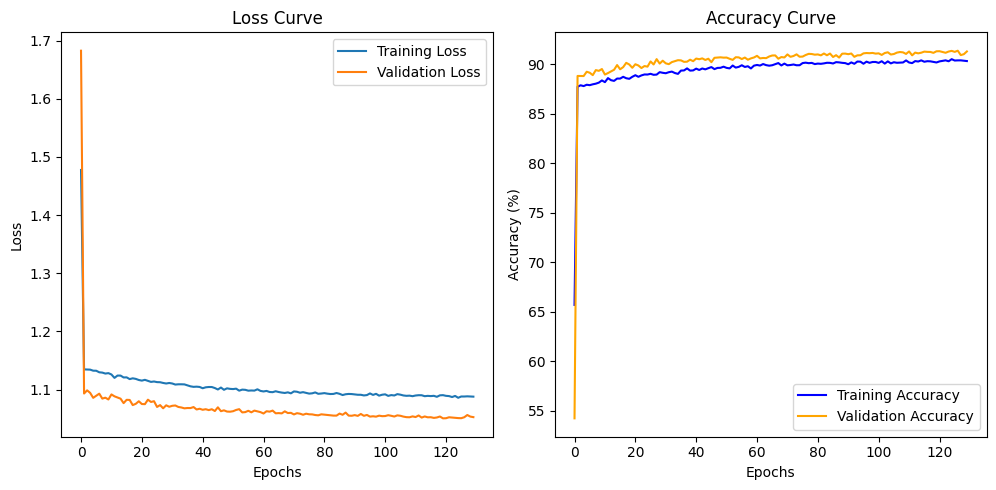

In [8]:
# Plotting learning curves
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
model.load_state_dict(torch.load("FFT-Resnet34-Mnist.pth"))

<All keys matched successfully>

In [16]:
def evaluate(model, loader):
    model.eval()
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to("cuda")
            labels = labels.to("cuda")

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')  
    accuracy = correct / total
    
    return accuracy, f1



print(evaluate(model, test_loader))